In [1]:
# specify train, validation and test path 
train_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/train'
val_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/val'
test_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/test'

# specify project directory in google drive
project_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/'

# saved model name
model_name = 'best_pretrained_resnet50.h5'

# Garbage Image Classification

## Objective 
To classify type of garbage in an image.  
This dataset contains 6 types of garbage;  
- cardboard (393 images)  
- glass (491 images)  
- metal (400 images)  
- paper (584 images)  
- plastic (472 images)  
- trash (127 images)

## Dataset
source : https://www.kaggle.com/asdasdasasdas/garbage-classification

## Approach
Baseline model : 
- NN model with pre-trained Keras ResNet50 as a feature extractor (untrainable)  

Improved model with
- train last block of pre-trained ResNet50
- data augmentation
- dropout layers

## Create Image Data Generator (without data augmentation)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## F-beta score function

In [3]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [4]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Evaluation function

In [5]:
import matplotlib.pyplot as plt

In [6]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

## Baseline model : CNN with pre-trained VGG16

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# create model

# load VGG16 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Epoch 1/100
89/89 [==============================] - 1516s 17s/step - loss: 4.1033 - fbeta: 0.5681 - val_loss: 0.9300 - val_fbeta: 0.7044
Epoch 2/100
89/89 [==============================] - 9s 99ms/step - loss: 0.3370 - fbeta: 0.8656 - val_loss: 0.8246 - val_fbeta: 0.8132
Epoch 3/100
89/89 [==============================] - 9s 99ms/step - loss: 0.1538 - fbeta: 0.9558 - val_loss: 0.8159 - val_fbeta: 0.8294
Epoch 4/100
89/89 [==============================] - 9s 98ms/step - loss: 0.0355 - fbeta: 0.9844 - val_loss: 0.7343 - val_fbeta: 0.8618
Epoch 5/100
89/89 [==============================] - 9s 99ms/step - loss: 0.0322 - fbeta: 0.9917 - val_loss: 0.8914 - val_fbeta: 0.8397
Epoch 6/100
89/89 [==============================] - 9s 98ms/step - loss: 0.0135 - fbeta: 0.9953 - val_loss: 0.8779 - val_fbeta: 0.8529
Epoch 7/100
89/89 [==============================] - 9s 98ms/step - loss: 0.0073 - fbeta: 0.9995 - val_loss: 0.8441 - val_fbeta: 0.8456
Epoch 8/100
89/89 [===========================

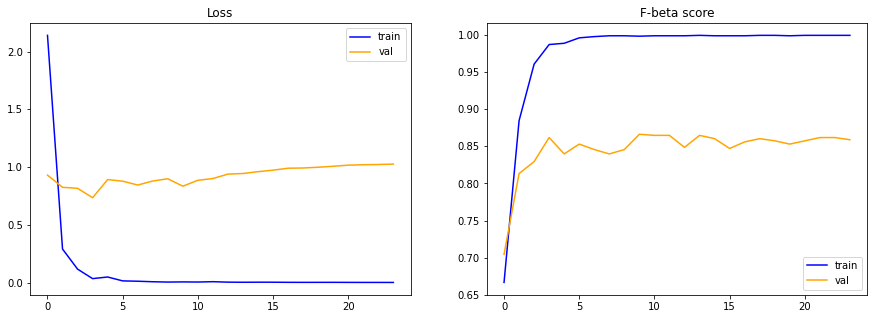

Model F-beta score :  0.8468676805496216


In [ ]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
baseline_perf = evaluate_model(history)

Note : there is overfitting

## Improved Models

### model 1 : baseline + set last block as trainable

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 12s 109ms/step - loss: 3.3810 - fbeta: 0.6052 - val_loss: 0.5750 - val_fbeta: 0.7853
Epoch 2/100
89/89 [==============================] - 9s 99ms/step - loss: 0.2018 - fbeta: 0.9104 - val_loss: 0.5893 - val_fbeta: 0.8500
Epoch 3/100
89/89 [==============================] - 9s 99ms/step - loss: 0.0897 - fbeta: 0.9739 - val_loss: 0.8051 - val_fbeta: 0.8176
Epoch 4/100
89/89 [==============================] - 9s 100ms/step - loss: 0.0659 - fbeta: 0.9739 - val_loss: 0.6465 - val_fbeta: 0.8485
Epoch 5/100
89/89 [==============================] - 9s 99ms/step - loss: 0.0261 - fbeta: 0.9901 - val_loss: 0.6415 - val_fbeta: 0.8603
Epoch 6/100
89/89 [==============================] - 9s 99ms/step - loss: 0.0109 - fbeta: 0.9969 - val_loss: 0.6584 - val_fbeta: 0.8485
Epoch 7/100
89/89 [==============================] - 9s 1

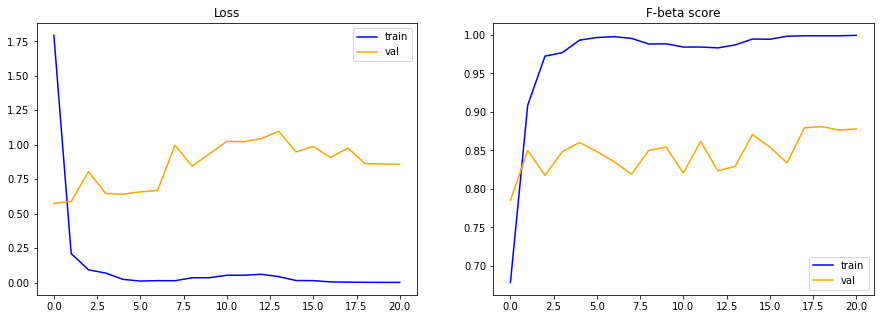

Model F-beta score :  0.8607887625694275


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last vgg block as trainable
#model.get_layer('conv5_block3_1_conv').trainable = True
#model.get_layer('conv5_block3_1_bn').trainable = True
#model.get_layer('conv5_block3_2_conv').trainable = True
#model.get_layer('conv5_block3_2_bn').trainable = True
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_3_bn').trainable = True
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model1_perf = evaluate_model(history)

Note : overfitting

### model 2 : Baseline + dropout layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 12s 113ms/step - loss: 3.8221 - fbeta: 0.4596 - val_loss: 0.7880 - val_fbeta: 0.6029
Epoch 2/100
89/89 [==============================] - 9s 99ms/step - loss: 0.6060 - fbeta: 0.7333 - val_loss: 0.6372 - val_fbeta: 0.7309
Epoch 3/100
89/89 [==============================] - 9s 101ms/step - loss: 0.4578 - fbeta: 0.7930 - val_loss: 0.6770 - val_fbeta: 0.7574
Epoch 4/100
89/89 [==============================] - 9s 99ms/step - loss: 0.3435 - fbeta: 0.8441 - val_loss: 0.6471 - val_fbeta: 0.7721
Epoch 5/100
89/89 [==============================] - 9s 99ms/step - loss: 0.2981 - fbeta: 0.8640 - val_loss: 0.7132 - val_fbeta: 0.7735
Epoch 6/100
89/89 [==============================] - 9s 99ms/step - loss: 0.2608 - fbeta: 0.8763 - val_loss: 0.7229 - val_fbeta: 0.8118
Epoch 7/100
89/89 [==============================] - 9s 9

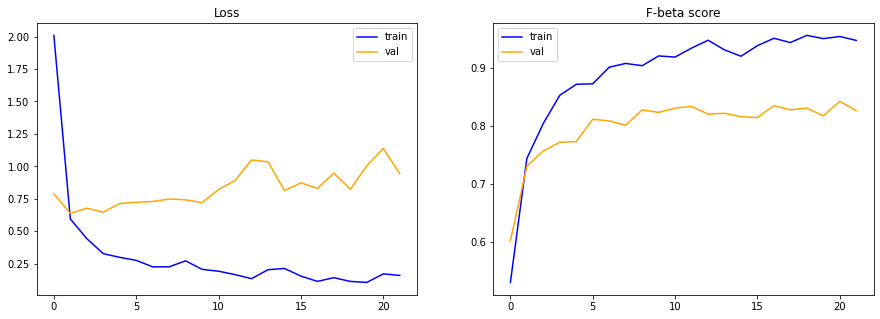

Model F-beta score :  0.8329465389251709


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(6, activation='softmax')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model2_perf = evaluate_model(history)

Note : overfitting is reduced

### model 3 : Baseline + data augmentation

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 19s 181ms/step - loss: 4.8827 - fbeta: 0.5305 - val_loss: 1.3975 - val_fbeta: 0.6338
Epoch 2/100
89/89 [==============================] - 15s 168ms/step - loss: 0.9357 - fbeta: 0.7153 - val_loss: 0.8058 - val_fbeta: 0.7353
Epoch 3/100
89/89 [==============================] - 15s 167ms/step - loss: 0.7032 - fbeta: 0.7221 - val_loss: 0.6870 - val_fbeta: 0.7382
Epoch 4/100
89/89 [==============================] - 15s 167ms/step - loss: 0.6119 - fbeta: 0.7650 - val_loss: 0.6932 - val_fbeta: 0.7500
Epoch 5/100
89/89 [==============================] - 15s 168ms/step - loss: 0.5096 - fbeta: 0.7955 - val_loss: 0.6353 - val_fbeta: 0.7926
Epoch 6/100
89/89 [==============================] - 15s 169ms/step - loss: 0.5029 - fbeta: 0.8226 - val_loss: 0.6234 - val_fbeta: 0.7941
Epoch 7/100
89/89 [=============================

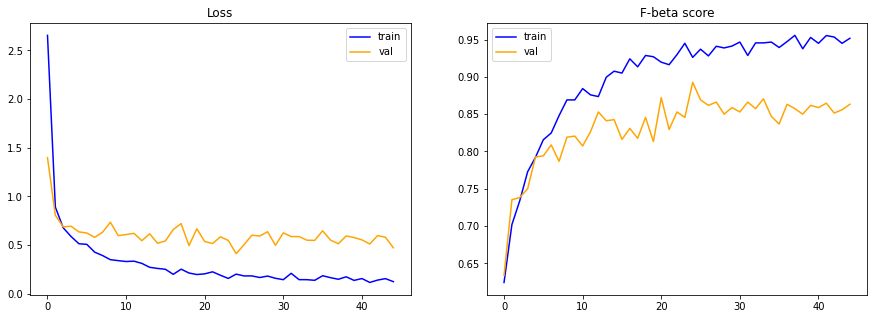

Model F-beta score :  0.865429162979126


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model3_perf = evaluate_model(history)

Note : overfitting is reduced, the performance increases

### model 4 : Baseline + data augmentation + more dense layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 17s 166ms/step - loss: 5.3044 - fbeta: 0.4800 - val_loss: 1.3118 - val_fbeta: 0.7191
Epoch 2/100
89/89 [==============================] - 14s 158ms/step - loss: 1.2287 - fbeta: 0.7120 - val_loss: 1.0785 - val_fbeta: 0.7368
Epoch 3/100
89/89 [==============================] - 14s 162ms/step - loss: 0.9792 - fbeta: 0.7388 - val_loss: 0.9475 - val_fbeta: 0.7824
Epoch 4/100
89/89 [==============================] - 14s 158ms/step - loss: 0.6261 - fbeta: 0.8124 - val_loss: 1.1427 - val_fbeta: 0.7456
Epoch 5/100
89/89 [==============================] - 14s 156ms/step - loss: 0.7013 - fbeta: 0.8126 - val_loss: 0.5924 - val_fbeta: 0.8132
Epoch 6/100
89/89 [==============================] - 14s 156ms/step - loss: 0.3996 - fbeta: 0.8470 - val_loss: 0.7202 - val_fbeta: 0.7971
Epoch 7/100
89/89 [=============================

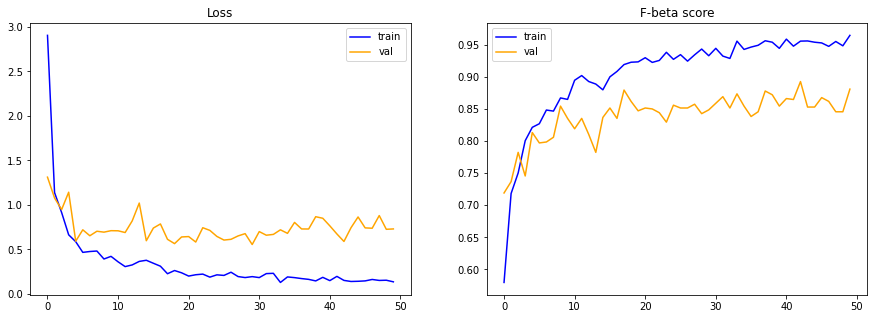

Model F-beta score :  0.8677493333816528


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(class1)
output = Dense(6, activation='softmax')(class2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model4_perf = evaluate_model(history)

Note : overfitting, the performance is little higher

### model 5 : Baseline + data augmentation + more dense layer + dropout layers

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 18s 166ms/step - loss: 6.2743 - fbeta: 0.4353 - val_loss: 1.0485 - val_fbeta: 0.6647
Epoch 2/100
89/89 [==============================] - 14s 155ms/step - loss: 1.4424 - fbeta: 0.6067 - val_loss: 0.8158 - val_fbeta: 0.6221
Epoch 3/100
89/89 [==============================] - 14s 156ms/step - loss: 1.2254 - fbeta: 0.5501 - val_loss: 0.8208 - val_fbeta: 0.5412
Epoch 4/100
89/89 [==============================] - 14s 157ms/step - loss: 1.1319 - fbeta: 0.5348 - val_loss: 0.8189 - val_fbeta: 0.5956
Epoch 5/100
89/89 [==============================] - 14s 157ms/step - loss: 1.0113 - fbeta: 0.6033 - val_loss: 0.8202 - val_fbeta: 0.6647
Epoch 6/100
89/89 [==============================] - 14s 157ms/step - loss: 0.8623 - fbeta: 0.6241 - val_loss: 0.8151 - val_fbeta: 0.5706
Epoch 7/100
89/89 [=============================

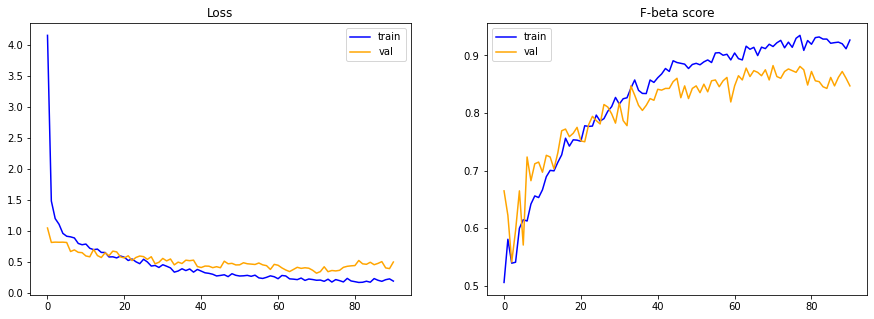

Model F-beta score :  0.8491878509521484


In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
# load VGG16 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class2)
output = Dense(6, activation='softmax')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model5_perf = evaluate_model(history)

Note : overfitting, the performance is lower

## Model performance :


In [ ]:
print('Baseline model : ', baseline_perf)
print('Model 1 : ', model1_perf)
print('Model 2 : ', model2_perf)
print('Model 3 : ', model3_perf)
print('Model 4 : ', model4_perf)
print('Model 5 : ', model5_perf)

Baseline model :  0.8468676805496216
Model 1 :  0.8607887625694275
Model 2 :  0.8329465389251709
Model 3 :  0.865429162979126
Model 4 :  0.8677493333816528
Model 5 :  0.8491878509521484


Note : every model have overfitting, then I choose model 4 to be finalized

## Finalize the model
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.


In [8]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical', shuffle=False)

# create model
# load VGG16 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(class1)
output = Dense(6, activation='softmax')(class2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es,mc],
                    epochs=300)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/300
89/89 [==============================] - 729s 8s/step - loss: 3.9423 - val_loss: 1.4409

Epoch 00001: val_loss improved from inf to 1.44091, saving model to best_pretrained_resnet50.h5
Epoch 2/300
89/89 [==============================] - 14s 162ms/step - loss: 0.8912 - val_loss: 0.7796

Epoch 00002: val_loss improved from 1.44091 to 0.77960, saving model to best_pretrained_resnet50.h5
Epoch 3/300
89/89 [==============================] - 14s 162ms/step - loss: 0.8299 - val_loss: 0.7448

Epoch 00003: val_loss improved from 0.77960 to 0.74475, saving model to best_pretrained_resnet50.h5
Epoch 4/300
89/89 [==============================] - 14s 162ms/step - loss: 0.5353 - val_loss: 0.6629

Epoch 00004: val_loss improved from 0.74475 to 0.66291, saving model to best_pretrained_resnet50.h5
Epoch

In [9]:
# get y_true
y_true = test_iter.classes
# get one-hot encoded y_true 
from keras.utils import to_categorical
y_true = to_categorical(y_true)

# get y_pred
import numpy as np
prediction = model.predict(test_iter)
y_pred = np.rint(prediction)

# print model score
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
print('Confusion Matrix')
print(confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nClassification Report')
print('\n', classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nmodel f2 score : ', fbeta_score(y_true, y_pred, 2, average='samples'))

Confusion Matrix
[[67  0  0  3  0  0]
 [ 0 66  3  0 13  0]
 [ 1  1 61  0  5  0]
 [ 7  0  3 93  4  1]
 [ 1  4  2  1 65  1]
 [ 1  0  5  3  2 18]]

Classification Report

               precision    recall  f1-score   support

           0       0.87      0.96      0.91        70
           1       0.93      0.80      0.86        82
           2       0.82      0.90      0.86        68
           3       0.93      0.86      0.89       108
           4       0.73      0.88      0.80        74
           5       0.90      0.62      0.73        29

    accuracy                           0.86       431
   macro avg       0.86      0.84      0.84       431
weighted avg       0.87      0.86      0.86       431


model f2 score :  0.8584686774941995


In [10]:
!ls

best_pretrained_resnet50.h5  drive  sample_data


In [11]:
# copy saved model file to the project directory
import shutil

shutil.copyfile(model_name, project_dir+model_name)

'/content/drive/MyDrive/MyProjects/garbage_img_classification/best_pretrained_resnet50.h5'